# GAN Pseudotime latent space interpolation

In [1]:
import numpy as np
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load data

In [2]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

from numpy import genfromtxt
#kasper_rank_matrix = genfromtxt('kasper_data_rank_normalised_top784_norownames.csv', delimiter=',', skip_header=1)
#kasper_rank_matrix = genfromtxt('kasper_data_raw_top784_v2.csv', delimiter=',', skip_header=1)

kasper_rank_matrix = genfromtxt('kasper_data_raw_full.csv', delimiter=',', skip_header=1)

#only use first 1000 cells
kasper_rank_matrix_unwitheld = kasper_rank_matrix
kasper_rank_matrix = kasper_rank_matrix[:,0:1000]

print(kasper_rank_matrix.shape)

import matplotlib.pyplot as plt
kasper_unprocessed_hst = np.hstack(kasper_rank_matrix)


(6707, 1000)


Parameters

In [3]:
n_train_steps = 30
batch_size = 256 #originally 128

noise_input_size = 100
#inflate_to_size = 1200
#output_size = 784
inflate_to_size = 600
gex_size = 6707

disc_internal_size = 200

### The Generator

In [4]:
def lrelu(x):
    return tf.maximum(x, 0.2 * x)

z = tf.placeholder(tf.float32, shape=(None, noise_input_size))
g_w1 = tf.get_variable("g_w1", [noise_input_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                      regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b1 = tf.get_variable("g_b1", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w2 = tf.get_variable("g_w2", [inflate_to_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b2 = tf.get_variable("g_b2", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w3 = tf.get_variable("g_w3", [inflate_to_size, gex_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b3 = tf.get_variable("g_b3", [gex_size], initializer=tf.constant_initializer(0.1))

g_params = [g_w1, g_b1, g_w2, g_b2, g_w3, g_b3]

def generator(z):
    g_y1 = lrelu(tf.matmul(z, g_w1) + g_b1)
    g_y2 = lrelu(tf.matmul(g_y1, g_w2) + g_b2)
    #G = tf.matmul(g_y2, g_w3) + g_b3
    G = tf.nn.relu(tf.matmul(g_y2, g_w3) + g_b3)
    #G = tf.nn.sigmoid(tf.matmul(g_y2, g_w3) + g_b3)
    
    #tensorboard
    tf.summary.histogram('layer1/g_y1', g_y1)
    tf.summary.histogram('layer2/g_y2', g_y2)
    tf.summary.histogram('layer3/out', G)
    return G

With the `noise_prior`, the choices to explore are the distribution used to generate the noise and the parameters of that distribution. The two obvious choices are the normal and uniform distribution. It seemed like a standard normal was a little more consistent in getting reasonable results.

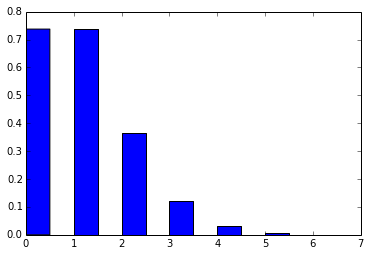

In [5]:
#changed so that max value in noise generation prior is max value of data

import numpy as np
s = np.random.poisson(1, 100000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 14, normed=True)
plt.show()

data_max_value = numpy.amax(kasper_rank_matrix)

def noise_prior(batch_size, dim):
    #return np.random.normal(0.0, data_max_value, size=(batch_size, dim))
    return np.random.poisson(1, size=(batch_size, dim))

### The Discriminator

In [6]:
x = tf.placeholder(tf.float32, shape=(None, gex_size))
d_w1 = tf.get_variable("d_w1", [gex_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005, 0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b1 = tf.get_variable("d_b1", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w2 = tf.get_variable("d_w2", [disc_internal_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b2 = tf.get_variable("d_b2", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w3 = tf.get_variable("d_w3", [disc_internal_size,1], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b3 = tf.get_variable("d_b3", [1], initializer=tf.constant_initializer(0.1))

d_params = [d_w1, d_b1, d_w2, d_b2, d_w3, d_b3]

#d_weights = [d_w1, d_w2, d_w3]

clip_d = None

def discriminator(x):
    d_y1 = lrelu(tf.matmul(x, d_w1) + d_b1)
    d_y2 = lrelu(tf.matmul(d_y1, d_w2) + d_b2)
    D = tf.matmul(d_y2, d_w3) + d_b3

    weights_d1 = tf.summary.histogram('d_layer1/d_w1', d_w1)
    weights_d2 = tf.summary.histogram('d_layer2/d_w2', d_w2)
    weights_d3 = tf.summary.histogram('d_layer3/d_w3', d_w3)

    bias_d1 = tf.summary.histogram('d_layer1/d_b1', d_b1)
    bias_d2 = tf.summary.histogram('d_layer2/d_b2', d_b2)
    bias_d3 = tf.summary.histogram('d_layer3/d_b3', d_b3)

    tf.summary.histogram('d_layer1/d_y1', d_y1)
    tf.summary.histogram('d_layer2/d_y2', d_y2)
    tf.summary.histogram('d_layer3/D', D)
    
    return D



Define the outputs we're going to train.

In [7]:
G = generator(z)
D_real = discriminator(x)
D_fake = discriminator(G)

### The Training Objectives

Changed for Wasserstein distance/objectives

In [8]:
print(D_real.shape)

(?, 1)


In [9]:
LAMBDA = 10 # Gradient penalty lambda hyperparameter

obj_d = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real)
obj_g = -tf.reduce_mean(D_fake)

##### need to expand shape of alpha?

alpha = tf.random_uniform(
    shape=[batch_size,gex_size], 
    minval=0.,
    maxval=1.
)

differences = D_fake - D_real
interpolates = D_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
obj_d += LAMBDA*gradient_penalty

In [10]:
def exp_decay(initial_rate, step, decay_factor, min_lr):
    return tf.maximum(initial_rate / tf.pow(decay_factor, tf.to_float(step)), min_lr)

def momentum_adjustor(initial_momentum, step, final_momentum, saturation_point):
    m = initial_momentum + (final_momentum - initial_momentum) * (tf.to_float(step) / saturation_point)
    return tf.minimum(m, final_momentum)

time_step = tf.placeholder(tf.int32)

d_batch = tf.Variable(0, trainable=False)
d_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
d_momentum = momentum_adjustor(0.5, d_batch, 0.7, 250)
#opt_d = tf.train.MomentumOptimizer(d_learning_rate, d_momentum).minimize(obj_d, var_list=d_params, global_step=d_batch)
opt_d = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_d, var_list=d_params)

g_batch = tf.Variable(0, trainable=False)
g_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
g_momentum = momentum_adjustor(0.5, g_batch, 0.7, 250)
#opt_g = tf.train.MomentumOptimizer(g_learning_rate, g_momentum).minimize(obj_g, var_list=g_params, global_step=g_batch)
opt_g = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_g, var_list=g_params)

d_momentum_summary = tf.summary.scalar('d_momentum', d_momentum)
g_momentum_summary = tf.summary.scalar('g_momentum', g_momentum)
d_learning_rate_summary = tf.summary.scalar('d_learning_rate', d_learning_rate)
g_learning_rate_summary = tf.summary.scalar('g_learning_rate', g_learning_rate)
obj_d_summary = tf.summary.scalar('obj_d', obj_d)
obj_g_summary = tf.summary.scalar('obj_g', obj_g)

#with tf.name_scope("layer1"):
#    weights_g1 = tf.summary.histogram('g_w1', g_w1)
#    bias_g1 = tf.summary.histogram('g_b1', g_b1)
#    layer1 = tf.matmul(z,g_w1)

weights_g1 = tf.summary.histogram('layer1/g_w1', g_w1)
weights_g2 = tf.summary.histogram('layer2/g_w2', g_w2)
weights_g3 = tf.summary.histogram('layer3/g_w3', g_w3)

bias_g1 = tf.summary.histogram('layer1/g_b1', g_b1)
bias_g2 = tf.summary.histogram('layer2/g_b2', g_b2)
bias_g3 = tf.summary.histogram('layer3/g_b3', g_b3)


### Generate cells from a checkpoint

In [11]:
checkpoint_path = "./models/wgan_gp_v2.ckpt"

sess=tf.InteractiveSession()

merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter("./summaries/gan_full_set_v8", sess.graph)

saver = tf.train.Saver(max_to_keep=50)

tf.global_variables_initializer().run()

saver.restore(sess, checkpoint_path)

def interpolate_two_cell_z(z_a, z_b, num_points):
    z_diff = z_b - z_a
    z_diff = numpy.true_divide(z_diff, num_points)

    z_output = z_a
    for step in range(1,num_points):
        z_step = z_a + step*z_diff
        z_output = numpy.append(z_output, z_step, axis=0)
        
    return z_output

z_test_a = noise_prior(1, 100)
z_test_b = noise_prior(1, 100)

interpolation_zab = interpolate_two_cell_z(z_test_a, z_test_b, 1000)
print(interpolation_zab.shape)
print(interpolation_zab[:,1].shape)

interp_gen = sess.run(G, {z : interpolation_zab })
print(interp_gen.shape)


INFO:tensorflow:Restoring parameters from ./models/wgan_gp_v2.ckpt
(1000, 100)
(1000,)
(1000, 6707)


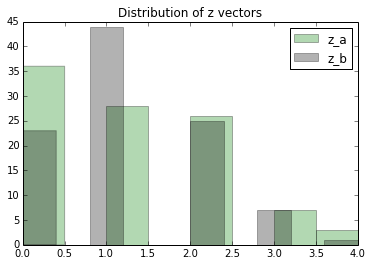

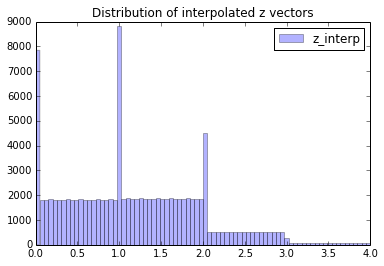

In [12]:
#histogram of original two and generated

#histogram of noise vectors Z
hst_za = np.hstack(z_test_a)
hst_zb = np.hstack(z_test_b)
hst_interp = np.hstack(interpolation_zab)

#z inputs
plt.hist(hst_za, bins='auto', alpha=0.3, label='z_a', color="green") # arguments are passed to np.histogram
plt.hist(hst_zb, bins='auto', alpha=0.3, label='z_b', color="black") # arguments are passed to np.histogram
plt.title("Distribution of z vectors")
pyplot.legend(loc='upper right')
savefig("z_input_histogram.pdf")
plt.show()

#interpolated z
plt.hist(hst_interp, bins='auto', alpha=0.3, label='z_interp', color="blue") # arguments are passed to np.histogram
plt.title("Distribution of interpolated z vectors")
pyplot.legend(loc='upper right')
savefig("z_interp_histogram.pdf")
plt.show()

In [13]:
#Calc tSNE
from sklearn.manifold import TSNE
n_genes_cov = 500

X = interp_gen

data_cov = numpy.var(interp_gen, axis=1)/numpy.mean(interp_gen, axis=1)
data_cov_index_desc = data_cov.argsort()[::-1][:n_genes_cov]

X = X[:,data_cov_index_desc]

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
combined_tsne = model.fit_transform(X)


(1000, 2)


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


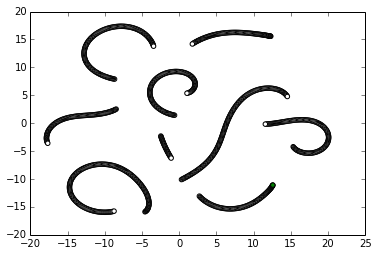

In [14]:
#Plot tSNE
import matplotlib.cm as cm

print(combined_tsne.shape)

tsne_color = np.concatenate([np.repeat("red",1), np.repeat("white",998), np.repeat("green",1)])

plt.scatter(combined_tsne[:,0],combined_tsne[:,1], c=tsne_color)
plt.show()

(1000, 500)


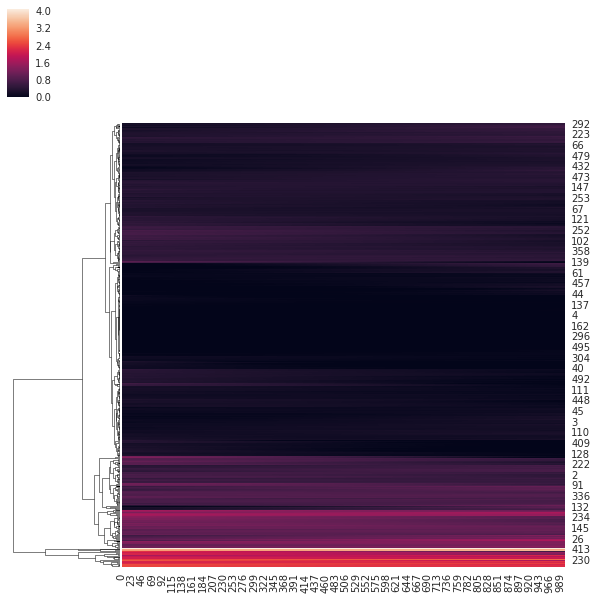

In [15]:
import seaborn as sns; sns.set()
print(X.shape)
g = sns.clustermap(np.transpose(X), col_cluster=False)
